In [1]:
import sys
sys.path.insert(0, '/root/conda/lib/python3.9/site-packages')

In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from fastcore.all import concat
from fastai.basics import show_image, show_images
from fastdownload import FastDownload

from pathlib import Path

from PIL import Image
import torch
import logging
logging.disable(logging.WARNING)

from torch import autocast
from torchvision import transforms as tfms

from huggingface_hub import notebook_login
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler, AutoPipelineForInpainting, DDIMScheduler

import cv2

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

In [4]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

#scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

In [5]:
def pil_to_latents(im):
    im = tfms.ToTensor()(im)[None,...]
    with torch.no_grad():
        latents = vae.encode(im.to(torch_device) * 2 - 1)  #scaling
    return 0.18215 * latents.latent_dist.sample()

def latents_to_pil(latents):
    # batch of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [6]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0]

In [30]:
def get_noise(prompts, image_latents,seed=torch.seed(), guidance_scale=7.5, strength=0.5, **kwargs):
    num_inference_steps = 50
    generator = torch.manual_seed(seed)
    
    text_emb = text_enc(prompts)
    unc_emb = text_enc([""])
    
    emb = torch.cat([text_emb, unc_emb])
    
    scheduler.set_timesteps(num_inference_steps)
    init_timestep = int(num_inference_steps * strength)
    init_timestep = min(init_timestep, num_inference_steps)
    
    timestep = scheduler.timesteps[-init_timestep]
    timestep = torch.tensor([timestep] * 1 * 1, device=torch_device)
    
    noise = torch.randn_like(image_latents)
    latents = scheduler.add_noise(image_latents, noise, timestep)
    latents = latents.to(torch_device).float()
    
    #start_time = max(num_inference_steps - init_timestep, 0)
    #timesteps = scheduler.timesteps[start_time:].to(torch_device)
    
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep)

    with torch.no_grad():
        noise_pred = unet(latent_model_input, timestep, encoder_hidden_states=emb).sample

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = scheduler.step(noise_pred, timestep, latents).pred_original_sample

    
    return latents.detach().cpu()

In [31]:
def get_mask(encoded_image, prompt1, prompt2, n=10, **kwargs):
    diffs = []
    
    torch.manual_seed(torch.seed() if 'seed' not in kwargs else kwargs['seed'])
    seeds = torch.randint(0, 2**62, (10,)).tolist()
    for i in range(n):
        kwargs['seed'] = seeds[i]
        latents1 = get_noise(prompt1, encoded_image, **kwargs)[0]
        latents2 = get_noise(prompt2, encoded_image, **kwargs)[0]
        
        diffs.append((np.array(latents1)-np.array(latents2)))
        
    mask = np.zeros_like(diffs[0])
    
    for i in range(n):
        mask += np.abs(diffs[i])
        
    mask = mask.mean(0)
    mask = (mask - mask.mean()) / np.std(mask)
    return (mask > 0).astype("uint8")

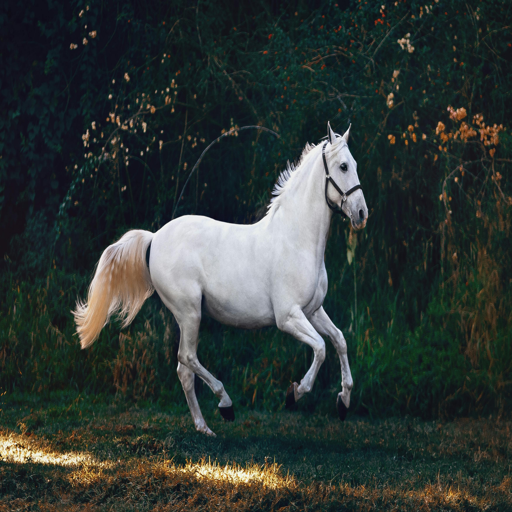

In [32]:
p = FastDownload().download('https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg?cs=srgb&dl=pexels-helena-lopes-1996333.jpg&fm=jpg&_gl=1*1pc0nw8*_ga*OTk4MTI0MzE4LjE2NjY1NDQwMjE.*_ga_8JE65Q40S6*MTY2Njc1MjIwMC4yLjEuMTY2Njc1MjIwMS4wLjAuMA..')
init_img = Image.open(p).resize((512,512))
init_img

In [33]:
init_latents = pil_to_latents(init_img)
init_latents.shape

torch.Size([1, 4, 64, 64])

In [34]:
m = get_mask(init_latents, ['A horse'], ['A zebra'])
m

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [35]:
m.shape

(64, 64)

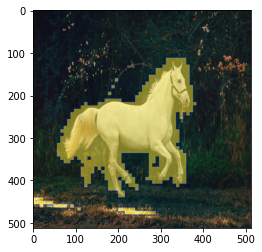

In [36]:
plt.imshow(np.array(init_img), cmap='gray');
plt.imshow(
    Image.fromarray(m).resize((512,512)), ## Scaling the mask to original size
    cmap='cividis', 
    alpha=0.5*(np.array(Image.fromarray(m*255).resize((512,512))) > 0)  
);

In [37]:
def diffedit(ref_prompt, query_prompt, init_image, mask, guidance=7.5, strength=0.5, num_inference_steps=50, seed=42):
    ref_emb = text_enc(ref_prompt)
    query_emb = text_enc(query_prompt)
    unc_emb = text_enc([""])
    
    emb = torch.cat([ref_emb, query_emb, unc_emb])
    
    if seed: torch.manual_seed(seed)
    
    scheduler.set_timesteps(num_inference_steps)
    init_latents = pil_to_latents(init_image)
    
    init_timestep = int(num_inference_steps * strength) 
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device=torch_device)
    
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    t_start = max(num_inference_steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:].to(torch_device)
    
    mask = torch.tensor(mask, dtype=unet.dtype)[None][None].to(torch_device)
    
    # print("Scheduler timesteps length:", len(scheduler.timesteps))
    # print("Max valid index:", len(scheduler.timesteps) - 1)
    
    for i,ts in enumerate(tqdm(timesteps)):
        
        inp = scheduler.scale_model_input(torch.cat([latents] * 3), ts)
        
        with torch.no_grad(): u, rt, qt = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(3)
        
        rpred = u + guidance*(rt-u)
        qpred = u + guidance*(qt-u)
        
        rlatents = scheduler.step(rpred, ts, latents).prev_sample
        qlatents = scheduler.step(qpred, ts, latents).prev_sample
        latents = mask*qlatents + (1-mask)*rlatents
        
    return latents_to_pil(latents)

  0%|          | 0/35 [00:00<?, ?it/s]

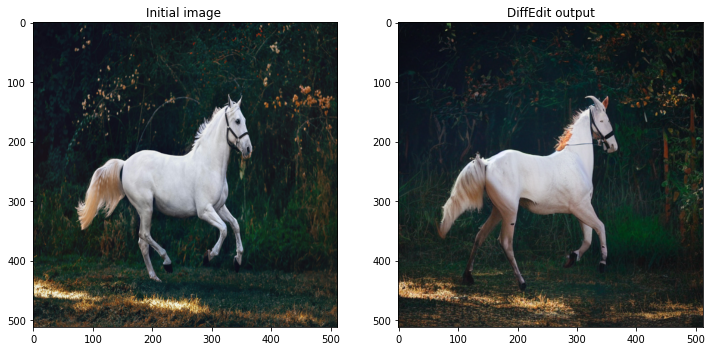

In [38]:
output = diffedit(
    ref_prompt = ["a horse image"], 
    query_prompt = ["a zebra image"],
    init_image=init_img, 
    mask = m, 
    guidance=7.5, seed=100, strength =0.5, num_inference_steps=70)

## Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for c, img in enumerate([init_img, output[0]]): 
    axs[c].imshow(img)
    if c == 0 : axs[c].set_title(f"Initial image ")
    else: axs[c].set_title(f"DiffEdit output")